## 1) 데이터 준비와 확인

In [261]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import seaborn as sns
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

  -  데이터의 중복 제거
  -  NaN 결측치 제거
  -  한국어 토크나이저로 토큰화
  -  불용어(Stopwords) 제거
  -  사전word_to_index 구성
  -  텍스트 스트링을 사전 인덱스 스트링으로 변환
  -  X_train, y_train, X_test, y_test, word_to_index 리턴

#### 데이터 전처리 특수 문자 제거

In [262]:
# 인공지능 작사가 만들기에서 가져왔으나 한글이라 좀 다르네요
# 감성분석이라 ! ~ ? 등이 감정 분석에 쓰일수 있을것 같다
def preprocess_sentence(sentence):
    #sentence = sentence.strip() #  한국어엔 소문자가 없음, 양쪽공백 지우기
    sentence = re.sub(r"([.?!~,¿@_;\"'])", r" \1 ", sentence) # 붙어있는 특수문자의 양쪽에 공백을 줘서 특수문자도 유의미하게 만들기
    sentence = re.sub(r'\s{1,}', r" ", sentence) # 여러공백을 공백 하나로
    sentence = re.sub(r'["."]+', ".", sentence) # 여러점을 점 하나로
    sentence = re.sub(r'["~"]+', "~", sentence) # 여러개을 하나로
    sentence = re.sub(r'["!"]+', "!", sentence) # 여러개을 하나로
    sentence = re.sub(r'["?"]+', "?", sentence) # 여러개을 하나로
    #sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 이거하면 한국어 날림
    #sentence = sentence.strip() # 5
    #sentence = re.sub(r'[" "]+', " ", sentence) # 여러공백을 공백 하나로
    sentence = re.sub(r"([.,¿@_;\"'])", "", sentence) #  특수문자 제거 ###
    # 6 이번예시는 뒤에서 bos(시작점)을 추가해준다
    #leng = len(sentence.split()) # 토큰 갯수 측정으로 전처리 이였는데 다른 예시에서 다른 해법을 찾았다
    #print(leng) 시험용
    sen = sentence.split() #토큰화
    return sen#반환에 추가

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("'나는 @_자연 ;;;인이다 ......... 별로 ,안맞는거. 같기도  .''"))


['나는', '자연', '인이다', '별로', '안맞는거', '같기도']


In [263]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') #NaN 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') #NaN 제거
    
    X_train = []
    for sentence in train_data['document']:
        #temp_X = tokenizer.morphs(sentence) # 토큰화       
        temp_X = preprocess_sentence(sentence) #특수문자 띄어쓰기 전처리 후 토큰화       
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        #temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = preprocess_sentence(sentence) #특수문자 띄어쓰기 전처리 후 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


### 원래는 이런식으로 공백,. 같은 특수 문자들이 포함되어 있다
{3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것',   
- !?~ 같은 감정을 느낄수 있는 문자만 남겨두고 삭제했다(preprocess_sentence)
- 비록 처리 단어량이 줄어들지는 않았지만 무의미한 단어를 줄여서 학습에 도움이 됬을 것이다

In [264]:
word_to_index

{'': 3,
 '!': 4,
 '영화': 5,
 '?': 6,
 '~': 7,
 '너무': 8,
 '정말': 9,
 '진짜': 10,
 '그냥': 11,
 '왜': 12,
 '이런': 13,
 '더': 14,
 '수': 15,
 '영화를': 16,
 '다': 17,
 '보고': 18,
 '그': 19,
 'ㅋㅋ': 20,
 '영화는': 21,
 '영화가': 22,
 '본': 23,
 '봤는데': 24,
 '최고의': 25,
 '아': 26,
 '이건': 27,
 '내가': 28,
 '없는': 29,
 '없다': 30,
 '드라마': 31,
 '완전': 32,
 '이렇게': 33,
 '참': 34,
 '이거': 35,
 '평점': 36,
 '그리고': 37,
 '이게': 38,
 '좋은': 39,
 '있는': 40,
 '연기': 41,
 '내': 42,
 '평점이': 43,
 '보는': 44,
 '다시': 45,
 '역시': 46,
 '스토리': 47,
 '난': 48,
 '많이': 49,
 '쓰레기': 50,
 '최고': 51,
 '것': 52,
 'ㅋ': 53,
 'ㅋㅋㅋ': 54,
 '없고': 55,
 'ㅠㅠ': 56,
 '재밌게': 57,
 '하는': 58,
 '또': 59,
 '꼭': 60,
 '-': 61,
 '보면': 62,
 '가장': 63,
 '아깝다': 64,
 '마지막': 65,
 '뭐': 66,
 '영화다': 67,
 '^^': 68,
 '무슨': 69,
 '하지만': 70,
 'ㅡㅡ': 71,
 'ㅎㅎ': 72,
 '10점': 73,
 '같은': 74,
 '작품': 75,
 '솔직히': 76,
 '끝까지': 77,
 '볼': 78,
 '넘': 79,
 '안': 80,
 '대한': 81,
 '만든': 82,
 '별로': 83,
 '봐도': 84,
 '전혀': 85,
 '그래도': 86,
 'ㅠ': 87,
 '같다': 88,
 '지금': 89,
 '말이': 90,
 '뭔가': 91,
 '아주': 92,
 '영화의': 93,
 '있다': 94

In [265]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word) # index 3부터 시작
#3번의 공백은 무의미하게 쓰인다 별의미는 없지만 밑에서 사용안됨으로 표시하여 확인 가능해질 것이다

{3: '', 4: '!', 5: '영화', 6: '?', 7: '~', 8: '너무', 9: '정말', 10: '진짜', 11: '그냥', 12: '왜', 13: '이런', 14: '더', 15: '수', 16: '영화를', 17: '다', 18: '보고', 19: '그', 20: 'ㅋㅋ', 21: '영화는', 22: '영화가', 23: '본', 24: '봤는데', 25: '최고의', 26: '아', 27: '이건', 28: '내가', 29: '없는', 30: '없다', 31: '드라마', 32: '완전', 33: '이렇게', 34: '참', 35: '이거', 36: '평점', 37: '그리고', 38: '이게', 39: '좋은', 40: '있는', 41: '연기', 42: '내', 43: '평점이', 44: '보는', 45: '다시', 46: '역시', 47: '스토리', 48: '난', 49: '많이', 50: '쓰레기', 51: '최고', 52: '것', 53: 'ㅋ', 54: 'ㅋㅋㅋ', 55: '없고', 56: 'ㅠㅠ', 57: '재밌게', 58: '하는', 59: '또', 60: '꼭', 61: '-', 62: '보면', 63: '가장', 64: '아깝다', 65: '마지막', 66: '뭐', 67: '영화다', 68: '^^', 69: '무슨', 70: '하지만', 71: 'ㅡㅡ', 72: 'ㅎㅎ', 73: '10점', 74: '같은', 75: '작품', 76: '솔직히', 77: '끝까지', 78: '볼', 79: '넘', 80: '안', 81: '대한', 82: '만든', 83: '별로', 84: '봐도', 85: '전혀', 86: '그래도', 87: 'ㅠ', 88: '같다', 89: '지금', 90: '말이', 91: '뭔가', 92: '아주', 93: '영화의', 94: '있다', 95: '내내', 96: '좋다', 97: '하고', 98: '근데', 99: '다른', 100: '최악의', 101: '할', 102: '않고', 103: '

In [266]:
print(len(index_to_word))

9997


In [267]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3
#3번의 공백은 무의미하게 쓰인다 별의미는 없지만 사용안됨으로 표시하여 확인 가능해질 것이다
index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['ㅋㅋ'])  # 20 이 출력됩니다. 
print(index_to_word[4])     # '!' 가 출력됩니다.

<BOS>
20
!


In [268]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [269]:
print(type(X_train))

<class 'list'>


In [270]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[26, 912, 10, 7412, 1095]
라벨:  0
1번째 리뷰 문장 길이:  5
2번째 리뷰 문장 길이:  6


In [271]:
print(get_decoded_sentence(X_train[0], index_to_word))

print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더빙 진짜 짜증나네요 목소리
라벨:  0


## 3) 모델구성을 위한 데이터 분석 및 가공

    데이터셋 내 문장 길이 분포
    적절한 최대 문장 길이 지정
    keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 데이터셋 내 문장 길이 분포

In [272]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_token = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_token)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(100 *np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  8.357266086137432
문장길이 최대 :  127
문장길이 표준편차 :  6.835978514998024
pad_sequences maxlen :  22
전체 문장의 93.95000486334014%가 maxlen 설정값 이내에 포함됩니다. 


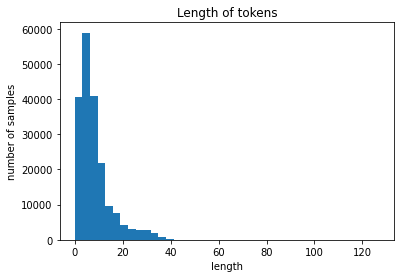

In [273]:
import matplotlib.pyplot as plt

plt.title('Length of tokens')
plt.hist(num_token, bins = 40)
plt.xlabel('length')
plt.ylabel('number of samples')
plt.show()
# 토큰의 길이 그래프

### 적절한 최대 문장 길이 지정

In [274]:
print(len(X_train))
len(X_test)
print(len(y_train))
print(type(y_train))
y_train

146182
146182
<class 'numpy.ndarray'>


array([0, 1, 0, ..., 0, 1, 0])

In [275]:
Xt = X_train
Yt = y_train.tolist()

count = 0
for i in range(len(Xt)):
    if len(Xt[i-count]) <= maxlen:
        pass
    else:
        del Xt[i-count]
        del Yt[i-count]
        count += 1
        # count가 없으니 list index에러가 나더라 지우는 순간 그 인덱스가 없어지고 
        #그 다음 인덱스가 앞을 채우니 나중에 최대 인덱스를 넘어가 버린것 한참 해맴
#혹시나 손상될까봐 Xt로 옮겨서 
# maxlen(22)보다 긴 문장들은 지워버림
nnt = [len(tokens) for tokens in Xt]        #각토큰의 길이 리스트nt 생성
nt = np.array(nnt) #넘파이 어레이화 (넘파이함수 max를 쓰기위해서)
print(np.max(nt)) #변경된 X_train의 토큰 길이의 최대치는 설정한대로 maxlen(22)
print(len(Xt)) #146182개가 137341이 되었다

y_train = np.array(Yt)

22
137341


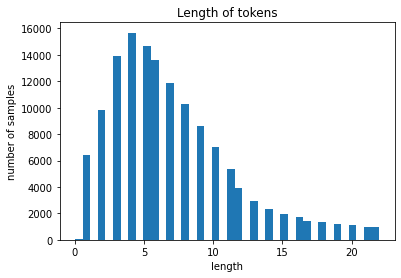

In [276]:
import matplotlib.pyplot as plt

plt.clf()
plt.title('Length of tokens')
plt.hist(nt, bins = 40)
plt.xlabel('length')
plt.ylabel('number of samples')
plt.show()
# 토큰의 길이 그래프
# 22 밑으로 잘 잘린걸 볼수있다

In [277]:
k = [0,1,2,3,4,5,6,7,8,9]
count = 0
for i in range(10):
    if k[i-count] < 6:
        pass
    else:
        del k[i-count]
        count += 1
print(k)    
print(len(k))
#파이썬 활용 확인차 모델과는 관련이 없다

[0, 1, 2, 3, 4, 5]
6


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [278]:
X_train = keras.preprocessing.sequence.pad_sequences(Xt,
                                                     value=word_to_index["<PAD>"],
                                                     padding='pre', # 혹은 'pre'
                                                     maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre', # 혹은 'pre'
                                                    maxlen=maxlen)
print(X_train.shape)

(137341, 22)


* **LSTM, GRU와 같은 recurrent model에서 토큰은 앞에서부터 뒤로 순차적으로 연산을 하게되고 뒤쪽의 새로한 연산의 중요성이 올라가는데 그 과정에서 제일 앞의 연산은 잊혀져간다(long-dependency 현상).**
* 여기서 pre패딩은 잊혀져가는 부분에 패딩을 배치함으로써 중요하지않은 패딩값을 잊어버리게되어 성능이 좋아진다.

## 4) 모델구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요. 

### 기본 모델

In [279]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [280]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model.add(keras.layers.LSTM(16))# default로 activation은 tanh, rec activation은 sigmoid를 사용합니다.
model.add(keras.layers.Dense(16, activation = 'relu'))# 출력의 차원을 양의 정수로 받습니다.
model.add(keras.layers.Dense(1, activation = 'sigmoid'))# 최종 출력은 긍정(1) 혹은 부정(0)의 숫자로 sigmoid를 사용합니다.
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 323,425
Trainable params: 323,425
Non-trainable params: 0
_________________________________________________________________


In [281]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model1.add(keras.layers.GRU(16))
model1.add(keras.layers.Dense(16, activation = 'tanh'))
model1.add(keras.layers.Dense(1))
model1.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
gru_6 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_32 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 322,689
Trainable params: 322,689
Non-trainable params: 0
_________________________________________________________________


In [282]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model2.add(keras.layers.SimpleRNN(16))
model2.add(keras.layers.Dense(16, activation = 'tanh'))
model2.add(keras.layers.Dense(1))
model2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dense_34 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 321,073
Trainable params: 321,073
Non-trainable params: 0
_________________________________________________________________


In [283]:
x_val = X_train[109873:]# 인덱싱을 활용하여 x__train의 109873건의 데이터를 분리합니다.
y_val = y_train[109873:] #20프로


p_x_train = X_train[:109873]# 를 x_train으로 사용합니다.
p_y_train = y_train[:109873]

print(p_x_train.shape)
print(p_y_train.shape)
print(x_val.shape)
print(y_val.shape) #위에 전처리시에 x쪽만 지워버려서 차원수가달라 작동이 안됬었다

(109873, 22)
(109873,)
(27468, 22)
(27468,)


## 5) 모델 훈련 개시

In [284]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
history = model.fit(p_x_train,p_y_train, 
                    batch_size=256, 
                    callbacks=[es],
                    epochs=50,
                    validation_data=(x_val, y_val))

Epoch 1/50
430/430 [==============================] - 6s 9ms/step - loss: 0.5645 - accuracy: 0.6913 - val_loss: 0.4213 - val_accuracy: 0.7875
Epoch 2/50
430/430 [==============================] - 3s 8ms/step - loss: 0.3764 - accuracy: 0.8168 - val_loss: 0.4054 - val_accuracy: 0.8037
Epoch 3/50
430/430 [==============================] - 3s 8ms/step - loss: 0.3567 - accuracy: 0.8270 - val_loss: 0.4076 - val_accuracy: 0.7997
Epoch 4/50
430/430 [==============================] - 4s 8ms/step - loss: 0.3453 - accuracy: 0.8321 - val_loss: 0.4093 - val_accuracy: 0.7990
Epoch 5/50
430/430 [==============================] - 3s 8ms/step - loss: 0.3358 - accuracy: 0.8365 - val_loss: 0.4157 - val_accuracy: 0.8018
Epoch 00005: early stopping


In [285]:
model1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
history1 = model1.fit(p_x_train,p_y_train, 
                    batch_size=256, 
                    callbacks=[es],
                    epochs=50,
                    validation_data=(x_val, y_val))

Epoch 1/50
430/430 [==============================] - 6s 9ms/step - loss: 0.9184 - accuracy: 0.6286 - val_loss: 0.4874 - val_accuracy: 0.7884
Epoch 2/50
430/430 [==============================] - 3s 8ms/step - loss: 0.4468 - accuracy: 0.8032 - val_loss: 0.4784 - val_accuracy: 0.7908
Epoch 3/50
430/430 [==============================] - 3s 8ms/step - loss: 0.4685 - accuracy: 0.7733 - val_loss: 0.5446 - val_accuracy: 0.7989
Epoch 4/50
430/430 [==============================] - 3s 8ms/step - loss: 0.4394 - accuracy: 0.7913 - val_loss: 0.4795 - val_accuracy: 0.7916
Epoch 5/50
430/430 [==============================] - 3s 8ms/step - loss: 0.3894 - accuracy: 0.8249 - val_loss: 0.5653 - val_accuracy: 0.7999
Epoch 6/50
430/430 [==============================] - 3s 8ms/step - loss: 0.3773 - accuracy: 0.8332 - val_loss: 0.5924 - val_accuracy: 0.6986
Epoch 7/50
430/430 [==============================] - 3s 8ms/step - loss: 0.3996 - accuracy: 0.8188 - val_loss: 0.6422 - val_accuracy: 0.7971
Epoch 

In [286]:
model2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
history2 = model2.fit(p_x_train,p_y_train, 
                    batch_size=256, 
                    callbacks=[es],
                    epochs=50,
                    validation_data=(x_val, y_val))

Epoch 1/50
430/430 [==============================] - 10s 21ms/step - loss: 0.9186 - accuracy: 0.5491 - val_loss: 0.5571 - val_accuracy: 0.7139
Epoch 2/50
430/430 [==============================] - 9s 21ms/step - loss: 0.4706 - accuracy: 0.7833 - val_loss: 0.5370 - val_accuracy: 0.7634
Epoch 3/50
430/430 [==============================] - 9s 21ms/step - loss: 0.4054 - accuracy: 0.8179 - val_loss: 0.5847 - val_accuracy: 0.7639
Epoch 4/50
430/430 [==============================] - 9s 21ms/step - loss: 0.3440 - accuracy: 0.8450 - val_loss: 0.6305 - val_accuracy: 0.7645
Epoch 5/50
430/430 [==============================] - 9s 21ms/step - loss: 0.3218 - accuracy: 0.8596 - val_loss: 0.6543 - val_accuracy: 0.7382
Epoch 6/50
430/430 [==============================] - 9s 21ms/step - loss: 0.3145 - accuracy: 0.8662 - val_loss: 0.8083 - val_accuracy: 0.7653
Epoch 7/50
430/430 [==============================] - 9s 21ms/step - loss: 0.2778 - accuracy: 0.8763 - val_loss: 0.8783 - val_accuracy: 0.764

In [289]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4240 - accuracy: 0.7972
[0.42404821515083313, 0.7971601486206055]


In [290]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 0.6643 - accuracy: 0.7855
[0.6642818450927734, 0.7855442762374878]


In [291]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 4s - loss: 1.1173 - accuracy: 0.7543
[1.1173248291015625, 0.7542974352836609]


## 6) Loss, Accuracy 그래프 시각화

In [287]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


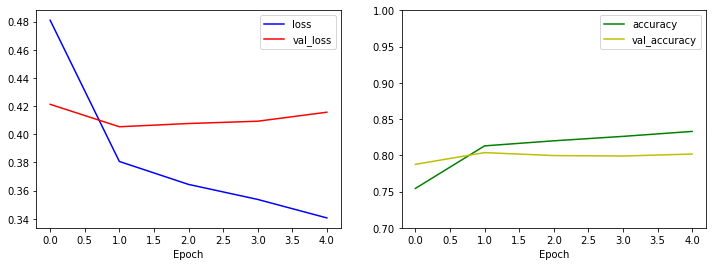

In [321]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'y-', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [292]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [293]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [295]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['ㅋㅋ']
vector

array([-0.034767  , -0.06142737, -0.03526218,  0.01295937,  0.03422119,
        0.04862869, -0.01207447,  0.00993351, -0.03654548, -0.00649386,
       -0.00124522, -0.02083097, -0.00753002,  0.05360267, -0.03346857,
        0.00869599,  0.01972065,  0.00349192,  0.02518002, -0.02062572,
       -0.00891546,  0.00124722, -0.03506735,  0.01622966,  0.02657956,
       -0.02391836, -0.05157876,  0.05017693, -0.02156322,  0.00058012,
       -0.07370741,  0.07878453], dtype=float32)

In [298]:
word_vectors.similar_by_word("감동")

[('괜찮은데', 0.907086193561554),
 ('명작이다', 0.8997926115989685),
 ('있었네', 0.8979502320289612),
 ('재미있었는데', 0.8946058750152588),
 ('귀여움', 0.8941439986228943),
 ('예뻐', 0.8938459157943726),
 ('대단해', 0.8929488062858582),
 ('있어요', 0.8925651907920837),
 ('바랍니다', 0.8902829885482788),
 ('좋은', 0.8893178701400757)]

In [328]:
word_vectors.similar_by_word("ㅋㅋ")

[('시작', 0.736244261264801),
 ('로빈', 0.6967207789421082),
 ('클라스', 0.6825221180915833),
 ('낮아서', 0.6787797808647156),
 ('good', 0.6785860061645508),
 ('좋은', 0.6781027317047119),
 ('아니지', 0.6771355271339417),
 ('추천한다', 0.6759920120239258),
 ('처음이었다', 0.6732069849967957),
 ('시청률은', 0.6726734042167664)]

In [330]:
word_vectors.similar_by_word("쓰레기")

[('재미없는', 0.9653439521789551),
 ('실수', 0.9644181728363037),
 ('했나요', 0.9619230628013611),
 ('한심한', 0.9550214409828186),
 ('내시간', 0.9511017203330994),
 ('2점', 0.9506291151046753),
 ('억지스런', 0.949946403503418),
 ('니들', 0.9497305750846863),
 ('어이상실', 0.9496792554855347),
 ('유치한', 0.9472143054008484)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [318]:
#!pip install --upgrade gensim==3.8.3
#왜 알려주신 방법대로 해도 안될까요
#원래 버젼대로 올려도 3.8.1로 내려도 안됩니다 별 하나 받을 운명인가봅니다

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [323]:
 !pip list | grep gensim

gensim                        3.8.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [327]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)


AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py'>

|No.|평가문항	|상세기준|
|-|:-|:-|
|1.| 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
|2.| gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3.| 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|	네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

# 회고
- 으 좀 늘은줄 알았는데 아직도 일정 주어진 형식에서 넘파이에서 리스트로 전환하거나 리스트를 넘파이로 전환하거나 그런걸 잘 파악하고 넘겨야 될거 같습니다 조금만 형식이 달라도 함수를 사용못하네요 ㅠ 
- 겐심 얘는 왜이러나 모르겠습니다 버젼 바꿔 설치해도 안됩니다